# Optimización de Portafolio en Python

Optimizacion de un Portafolio con Oro, Plata y SP-500 como activos solidos en un entorno de alta inflación

### Obtención de Datos e Importación de Librerias

Cargar Yahoo Finance, matplotlib y numpy; Descargar datos de precios desde el 1 de enero de 2016 al 1 de enero de 2026

In [53]:
import yfinance as yf
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.optimize import minimize

data = yf.download(['GC=F', 'SI=F', '^GSPC'], start='2016-01-01', end='2026-01-01', auto_adjust=False)['Close']

[*********************100%***********************]  3 of 3 completed


In [54]:
data.head()

Ticker,GC=F,SI=F,^GSPC
Date,,,
2016-01-04,1075.099976,13.817,2012.660034
2016-01-05,1078.400024,13.949,2016.709961
2016-01-06,1091.900024,13.957,1990.260010
2016-01-07,1107.699951,14.335,1943.089966
2016-01-08,1097.800049,13.908,1922.030029


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

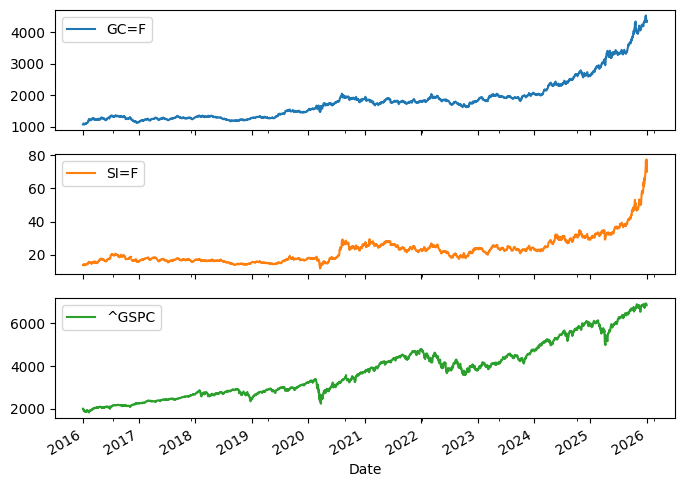

In [55]:
data.plot(figsize = (8,6), subplots=True)

#### Calculando Retornos

In [56]:
data.pct_change()

Ticker,GC=F,SI=F,^GSPC
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,0.003070,0.009553,0.002012
2016-01-06,0.012519,0.000573,-0.013115
2016-01-07,0.014470,0.027083,-0.023700
2016-01-08,-0.008937,-0.029787,-0.010838
...,...,...,...
2025-12-24,-0.000491,0.007746,0.003221
2025-12-26,0.010824,0.076797,-0.000304
2025-12-29,-0.045042,-0.086682,-0.003492


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

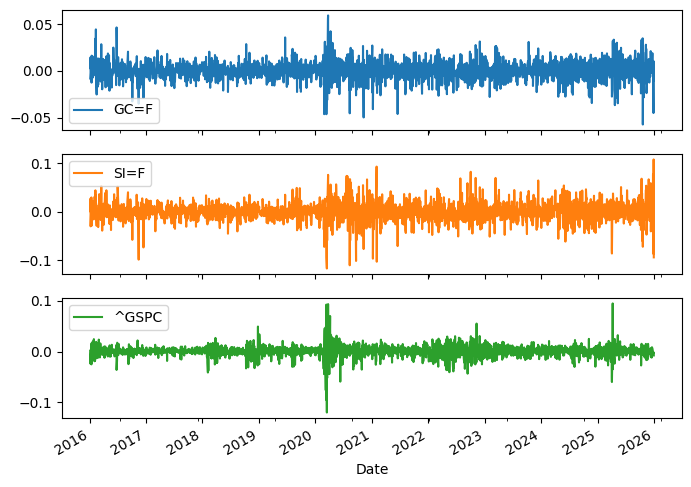

In [57]:
data.pct_change().plot(figsize = (8,6), subplots=True)

In [58]:
#Calcular Retornos Diarios
retornos_diarios = data.pct_change()

#Calcular Rendimiento Anualizado
rendimiento_anualizado = (1 + retornos_diarios.mean()) ** 252 - 1

#Mostrar Resultado
print("Rendimiento Anual: {0}".format(rendimiento_anualizado))

Rendimiento Anual: Ticker
GC=F     0.163321
SI=F     0.230478
^GSPC    0.149261
dtype: float64


In [59]:
#Calcular Volatilidad
volatilidad_anualizada = retornos_diarios.std() * (252 ** 0.5)

#Mostrar Resultado
print("Volatilidad Anual: {0}".format(volatilidad_anualizada))

Volatilidad Anual: Ticker
GC=F     0.153556
SI=F     0.298361
^GSPC    0.181214
dtype: float64


### Optimizacion de Portafolios

In [60]:
#Calcular la Matriz de Covarianza

covarianzas_diarias = retornos_diarios.cov()
covarianza_anualizada = covarianzas_diarias * 252


In [82]:
#Generar Portafolios

rendimientos = []
riesgos = []
portafolios = []

pesos_oro = np.linspace(0, 1, 101)
pesos_plata = np.linspace(0, 1, 101)
for po in pesos_oro:
    for pp in pesos_plata:
        w1 = po
        w2 = pp
        w3 = 1 - w1 - w2
            
        pesos = np.array([w1, w2, w3])

        #Calcular Rendimiento
        rendimiento = np.dot(pesos, rendimiento_anualizado)

        #Calcular Riesgo 
        riesgo = np.sqrt(np.dot(pesos.T, np.dot(covarianza_anualizada, pesos)))

        #Guardar Resultados
        rendimientos.append(rendimiento)
        riesgos.append(riesgo)
        portafolios.append(pesos)

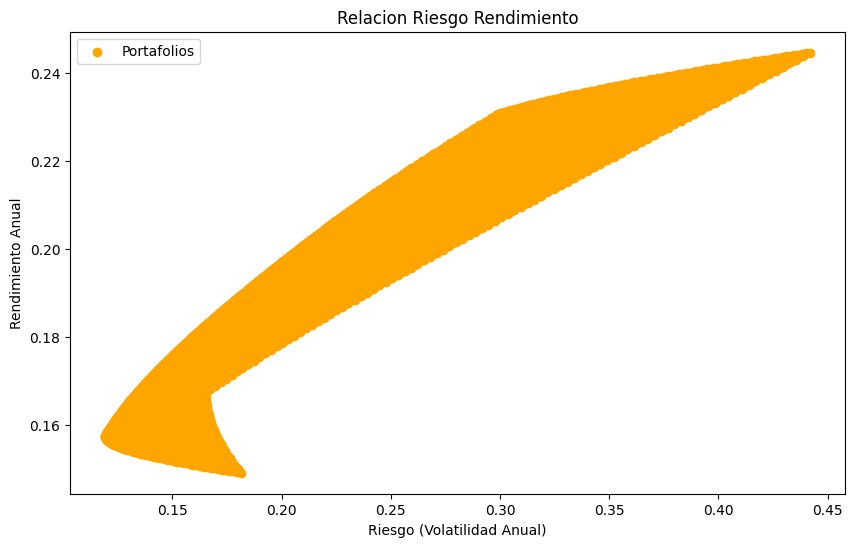

In [83]:
#Graficar Frontera Eficiente
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()

### Volatibilidad Mínima

In [74]:
#Función Objetivo: Minimizar la varianza del Portafolio

def varianza_minima(w, cov):
    return np.dot(w.T, np.dot(cov, w))

In [72]:
#Restricciones: Pesos deben sumar 1

restricciones = (
    {"type": "eq", "fun": lambda w: np.sum(w) -1}
)

In [68]:
#limites: deben estar entre 0 y 1
limites = [(0, 1) for _ in range(len(covarianzas_diarias))]

In [69]:
#Pesos Iniciales
pesos_iniciales = np.array([0.33, 0.33, 0.34])

In [75]:
#Optimización
resultado = minimize(
    varianza_minima,
    pesos_iniciales,
    args=(covarianza_anualizada,),
    constraints = restricciones, 
    bounds = limites,
    method = "SLSQP"
)

In [76]:
#Peso Varianza Minima
pesos_min_var = resultado.x
print("Pesos Varianza Minima: {0}",format(pesos_min_var))

Pesos Varianza Minima: {0} [5.85263056e-01 7.37257477e-18 4.14736944e-01]


In [77]:
rendimiento_min_var = np.dot(pesos_min_var, rendimiento_anualizado)
riesgo_min_var = np.sqrt(np.dot(pesos_min_var.T, np.dot(covarianza_anualizada, pesos_min_var)))

print("Rendimiento: {0}".format(rendimiento_min_var))
print("Riesgo: {0}".format(riesgo_min_var))

Rendimiento: 0.15748958147682546
Riesgo: 0.11933159362540798


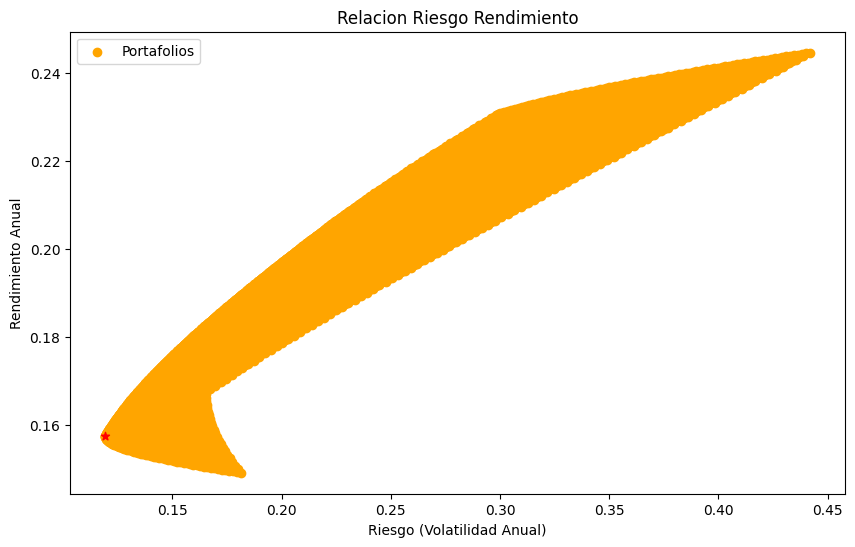

In [84]:
plt.figure(figsize=(10, 6))
plt.scatter(riesgos, rendimientos, label="Portafolios", color="orange")
plt.scatter(riesgo_min_var, rendimiento_min_var, color="red", marker="*")

plt.title("Relacion Riesgo Rendimiento")
plt.xlabel("Riesgo (Volatilidad Anual)")
plt.ylabel("Rendimiento Anual")
plt.legend(loc="upper left")

plt.show()